In [286]:
import findspark
findspark.init()
import mysql.connector
from distutils.sysconfig import get_python_lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
sns.set_palette("GnBu_d")
import pyspark 
from pyspark.sql import *
from pyspark.sql.functions import col, lit, when,expr, trim
import datetime

In [287]:
today = datetime.date.today()
year = today.year


In [288]:
# Configurer la configuration 
conf = pyspark.SparkConf() 
spark_context = SparkSession.builder.getOrCreate() 

In [289]:
appName = "PySpark MySQL Example - via mysql.connector"
master = "local"

spark = SparkSession.builder.master(master).appName(appName).getOrCreate()


In [290]:
# Establish a connection
conn = mysql.connector.connect(user='root', database='webscrapping',
                               password='',
                               host="localhost",
                               port=3306)

In [291]:
cursor = conn.cursor()

In [292]:
query = "SELECT marque, modele, CONVERT(cars_info.kilometrage, UNSIGNED INTEGER) AS kilometrage, carburant, CONVERT(cars_info.prix, UNSIGNED INTEGER) AS prix, CONVERT(cars_info.annee, UNSIGNED INTEGER) AS annee, transmission FROM webscrapping.cars_info  WHERE  cars_info.annee <> 'N/A' AND CONVERT(cars_info.annee, UNSIGNED INTEGER) > 1950 AND CONVERT(cars_info.kilometrage, UNSIGNED INTEGER) > 10000 AND  cars_info.transmission IN ('Automatique','Manuelle', 'Manuel') AND  CONVERT(cars_info.prix, UNSIGNED INTEGER)  BETWEEN 100000 AND 100000000 AND carburant is not null"
# Create a pandas dataframe
pdf = pd.read_sql(query, con=conn)
conn.close()

In [293]:
# Convert Pandas dataframe to spark DataFrame
df = spark.createDataFrame(pdf)

df.show()

+-------------+--------------+-----------+---------+--------+-----+------------+
|       marque|        modele|kilometrage|carburant|    prix|annee|transmission|
+-------------+--------------+-----------+---------+--------+-----+------------+
|          Kia|      Sportage|      32000|  Essence|12800000| 2019|    Manuelle|
|         Ford|        Ranger|      23000|  Essence|16000000| 2020| Automatique|
|         Ford|        Fusion|      77000|  Essence| 5500000| 2014| Automatique|
|          Kia|      Sportage|      73000|   Diesel|12000000| 2016| Automatique|
|         Ford|        Fusion|      70460|  Essence| 4500000| 2015| Automatique|
|       Toyota|         Rav 4|      93000|  Essence| 4200000| 2007| Automatique|
|       Toyota|      Fortuner|     175000|  Essence| 9980000| 2011| Automatique|
|         Jeep|      Cherokee|     115000|  Essence| 8900000| 2014| Automatique|
|      Citroen|            C3|     125000|   Diesel| 4300000| 2015|    Manuelle|
|          BMW|            X

In [294]:
#Enlever les valeurs non essentielles
df1 = df.filter(col("carburant") != " ") \
        .filter(col("carburant") != "Gaz") \
        .filter(col("carburant") != "Gas") \
        .filter(col("carburant") != "Autre") \
        .filter(col("marque") != "Autre") \
        .filter(col("marque") != "Autobianchi")\
        .filter(col("marque") != "Brilliance") \
        .filter(col("marque") != "Mahindra") \
        .filter(col("marque") != "Youngman") \
        .filter(col("annee") <= year)

df2 = df1.withColumn("carburant", when(df1.carburant == " Essence", "Essence").when(df1.carburant == "Gasoil", "Diesel").otherwise(df.carburant))\
        .withColumn("transmission", when(df1.transmission == "Manuel", "Manuelle").otherwise(df1.transmission))
df2.select("transmission", "carburant").distinct().show()

+------------+----------+
|transmission| carburant|
+------------+----------+
| Automatique|    Diesel|
| Automatique|   Essence|
|    Manuelle|    Diesel|
| Automatique|    Hybrid|
|    Manuelle|   Essence|
| Automatique|Electrique|
|    Manuelle|    Hybrid|
|    Manuelle|Electrique|
+------------+----------+



In [295]:
# Supprimer les doublons
print("Distinct count: "+str(df2.count()))
df3 = df2.dropDuplicates()
print("Distinct count: "+str(df3.count()))

Distinct count: 52677
Distinct count: 33965


In [296]:
# enlever les espaces au début et à la fin de chaque valeurs 
df4 = df3.withColumn('marque', trim(df3.marque)) \
        .withColumn('modele', trim(df3.modele)) \
        .withColumn('kilometrage', trim(df3.kilometrage)) \
        .withColumn('prix', trim(df3.prix)) \
        .withColumn('annee', trim(df3.annee)) \
        .withColumn('transmission', trim(df3.transmission))

# df4.show(truncate=False)

In [297]:
# standariser le nom des marques
df5 = df4.withColumn("marque", when(col('marque').like("%Infinity%"), "Infiniti") \
        .when(col('marque').like("%Cherry%"), "Chery") \
        .when(col('marque').like("%Land%"), "Land Rover") \
        .when(col('marque').like("%Range%"), "Land Rover") \
        .when(col('marque').like("%Mercedes%"), "Mercedes-Benz") \
        .when(col('marque').like("%FORD%"), "Ford") \
        .otherwise(df4.marque))


In [264]:
df5.select("kilometrage").distinct().sort(col("kilometrage").asc()).show(10000,truncate=False)

+-----------+
|kilometrage|
+-----------+
|100000     |
|1000000    |
|100007     |
|100012     |
|10002      |
|100050     |
|100068     |
|100085     |
|100086     |
|100100     |
|100109     |
|100130     |
|100150     |
|100178     |
|100203     |
|100223     |
|100233     |
|100254     |
|100284     |
|100300     |
|100301     |
|100312     |
|100322     |
|100339     |
|100357     |
|100365     |
|100369     |
|100391     |
|10040      |
|100400     |
|100450     |
|100500     |
|100541     |
|100552     |
|100578     |
|100586     |
|100600     |
|100644     |
|100659     |
|100700     |
|100800     |
|100864     |
|10090      |
|100900     |
|10096      |
|10100      |
|101000     |
|101050     |
|101091     |
|101111     |
|101197     |
|101200     |
|101203     |
|101223     |
|101250     |
|101252     |
|101271     |
|101281     |
|101282     |
|101397     |
|101400     |
|101421     |
|101531     |
|101681     |
|101700     |
|101737     |
|101754     |
|101803     |
|10182

In [265]:
df5.select("marque","modele").distinct().where(col('marque') == "BMW").sort(col("modele").asc()).show(10000,truncate=False)

+------+--------+
|marque|modele  |
+------+--------+
|BMW   |1       |
|BMW   |3       |
|BMW   |3–Series|
|BMW   |5       |
|BMW   |535     |
|BMW   |5GT     |
|BMW   |5er     |
|BMW   |5–Series|
|BMW   |6       |
|BMW   |6er     |
|BMW   |7       |
|BMW   |7-Series|
|BMW   |750     |
|BMW   |8       |
|BMW   |E30     |
|BMW   |E46     |
|BMW   |E90     |
|BMW   |GT      |
|BMW   |M3      |
|BMW   |M5      |
|BMW   |M6      |
|BMW   |Rapide  |
|BMW   |Serie 1 |
|BMW   |Serie 3 |
|BMW   |Serie 4 |
|BMW   |Serie 5 |
|BMW   |Serie 8 |
|BMW   |Série 3 |
|BMW   |X1      |
|BMW   |X2      |
|BMW   |X3      |
|BMW   |X4      |
|BMW   |X5      |
|BMW   |X5M     |
|BMW   |X6      |
|BMW   |X6 M    |
|BMW   |X6M     |
|BMW   |Z1      |
|BMW   |Z3M     |
|BMW   |Z4      |
|BMW   |Z8      |
|BMW   |ix      |
+------+--------+



In [298]:
df6 = df5.withColumn("modele", when((col("modele") == "1") & (col("marque") == "BMW"), "Serie 1")
                                .when(((col("modele") == "3") | (col("modele") == "Série 3") | (col("modele") == "3–Series")) & (col("marque") == "BMW"), "Serie 3") \
                                .when(((col("modele") == "5") | (col("modele") == "Série 5") | (col("modele") == "5–Series")) & (col("marque") == "BMW"), "Serie 5") \
                                .when(((col("modele") == "6") | (col("modele") == "Série 6") | (col("modele") == "6–Series")) & (col("marque") == "BMW"), "Serie 6") \
                                .when(((col("modele") == "6") | (col("modele") == "Série 7") | (col("modele") == "7–Series")) & (col("marque") == "BMW"), "Serie 7") \
                                .when(((col("modele") == "8") | (col("modele") == "Série 8") | (col("modele") == "8–Series")) & (col("marque") == "BMW"), "Serie 8") \
                                .otherwise(df4.modele))

In [267]:
df6.select("marque","modele").distinct().where(col('marque') == "BMW").sort(col("modele").asc()).show(10000,truncate=False)

+------+--------+
|marque|modele  |
+------+--------+
|BMW   |535     |
|BMW   |5GT     |
|BMW   |5er     |
|BMW   |6er     |
|BMW   |7       |
|BMW   |7-Series|
|BMW   |750     |
|BMW   |E30     |
|BMW   |E46     |
|BMW   |E90     |
|BMW   |GT      |
|BMW   |M3      |
|BMW   |M5      |
|BMW   |M6      |
|BMW   |Rapide  |
|BMW   |Serie 1 |
|BMW   |Serie 3 |
|BMW   |Serie 4 |
|BMW   |Serie 5 |
|BMW   |Serie 6 |
|BMW   |Serie 8 |
|BMW   |X1      |
|BMW   |X2      |
|BMW   |X3      |
|BMW   |X4      |
|BMW   |X5      |
|BMW   |X5M     |
|BMW   |X6      |
|BMW   |X6 M    |
|BMW   |X6M     |
|BMW   |Z1      |
|BMW   |Z3M     |
|BMW   |Z4      |
|BMW   |Z8      |
|BMW   |ix      |
+------+--------+



Convert PySpark DataFrame to Pandas

In [299]:
dataframe = df6.toPandas()
dataframe.head()

,marque,modele,kilometrage,carburant,prix,annee,transmission
0,Mitsubishi,Outlander,151000,Essence,5300000,2012,Automatique
1,BMW,Serie 3,96000,Essence,9200000,2013,Automatique
2,Ford,Fusion,114000,Essence,4000000,2014,Automatique
3,Ford,Explorer,129000,Essence,9700000,2013,Automatique
4,Fiat,500,28500,Essence,2700000,2010,Manuelle


In [300]:
# Information of the data
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33965 entries, 0 to 33964
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   marque        33965 non-null  object
 1   modele        33965 non-null  object
 2   kilometrage   33965 non-null  object
 3   carburant     33965 non-null  object
 4   prix          33965 non-null  object
 5   annee         33965 non-null  object
 6   transmission  33965 non-null  object
dtypes: object(7)
memory usage: 1.8+ MB


# Preprocessing

In [301]:
dataframe.describe(include='all')

,marque,modele,kilometrage,carburant,prix,annee,transmission
count,33965,33965,33965,33965,33965,33965,33965
unique,66,870,3054,4,979,41,2
top,Ford,Escape,100000,Essence,4500000,2013,Automatique
freq,8769,2722,1965,26123,934,5922,24943


In [271]:
dataframe.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

,marque,modele,kilometrage,carburant,prix,annee,transmission
count,33968,33968,33968,33968,33968,33968,33968
unique,66,870,3054,5,979,41,2
top,Ford,Escape,100000,Essence,4500000,2013,Automatique
freq,8769,2722,1965,26123,935,5924,24943


**Check for any missing value in data set and treat it**

In [302]:
# checking missing value
dataframe.isna().sum()

marque          0
modele          0
kilometrage     0
carburant       0
prix            0
annee           0
transmission    0
dtype: int64

In [303]:

# Creating a new feature called total no. of years old my car,bcz It's important to know how many years old the car is.
dataframe['car_age'] = year-dataframe['annee'].astype(str).astype(int)
dataframe['prix'] = dataframe['prix'].astype(str).astype(int)
dataframe['kilometrage'] = dataframe['kilometrage'].astype(str).astype(int)

#It's time to drop the Year column after the needed info is derived.
dataframe.drop(labels='annee',axis=1,inplace=True)

In [304]:
dataframe.head()

,marque,modele,kilometrage,carburant,prix,transmission,car_age
0,Mitsubishi,Outlander,151000,Essence,5300000,Automatique,11
1,BMW,Serie 3,96000,Essence,9200000,Automatique,10
2,Ford,Fusion,114000,Essence,4000000,Automatique,9
3,Ford,Explorer,129000,Essence,9700000,Automatique,10
4,Fiat,500,28500,Essence,2700000,Manuelle,13


# Data exploration

**Data Exploration & Visualization**

Text(0.5, 1.0, 'Prix de la voiture Vs Transmission')

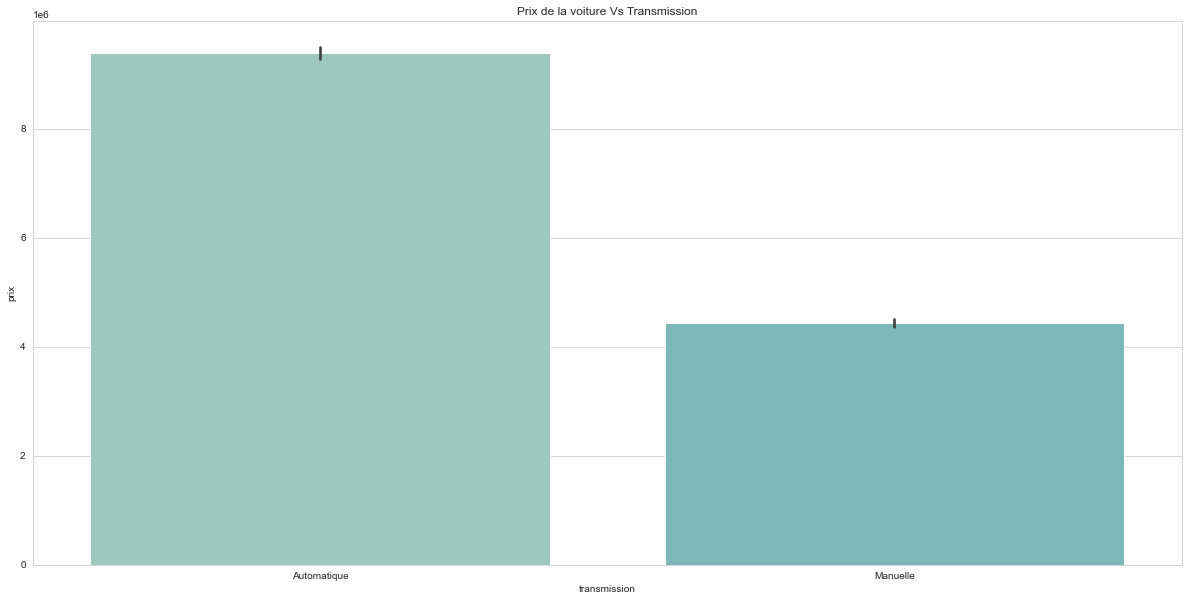

In [305]:
plt.figure(figsize=[70,10])
plt.subplot(1,3,2)
sns.barplot(dataframe['transmission'],dataframe['prix'])
plt.title('Prix de la voiture Vs Transmission')



Text(0.5, 1.0, 'Prix de la voiture Vs Type de carburant')

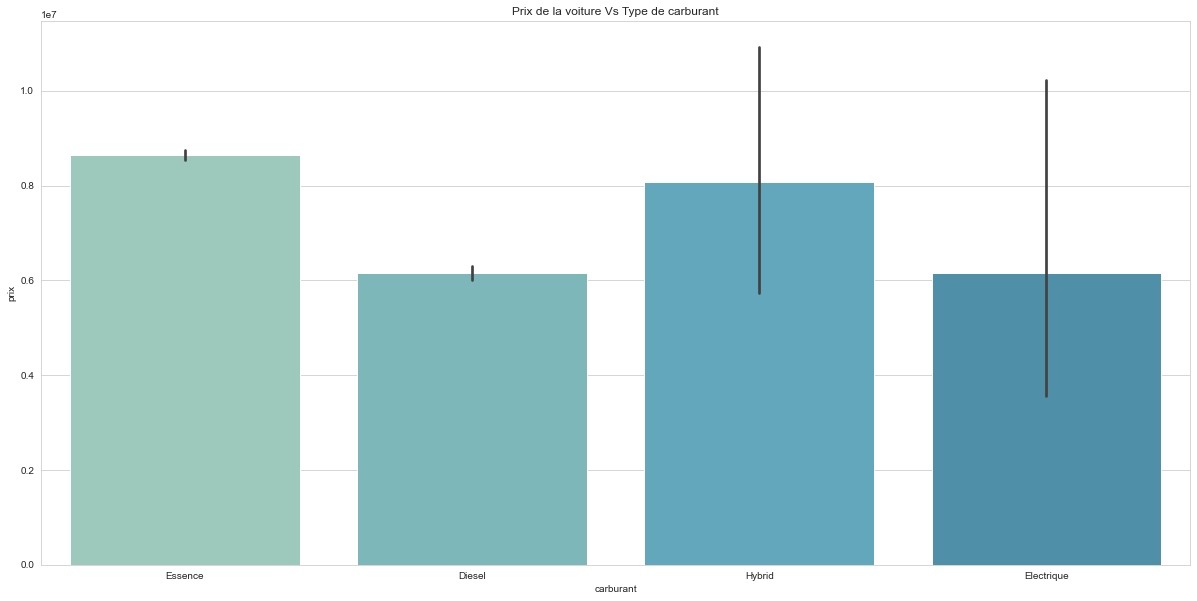

In [306]:
plt.figure(figsize=[70,10])
plt.subplot(1,3,3)
sns.barplot(dataframe['carburant'],dataframe['prix'])
plt.title('Prix de la voiture Vs Type de carburant')

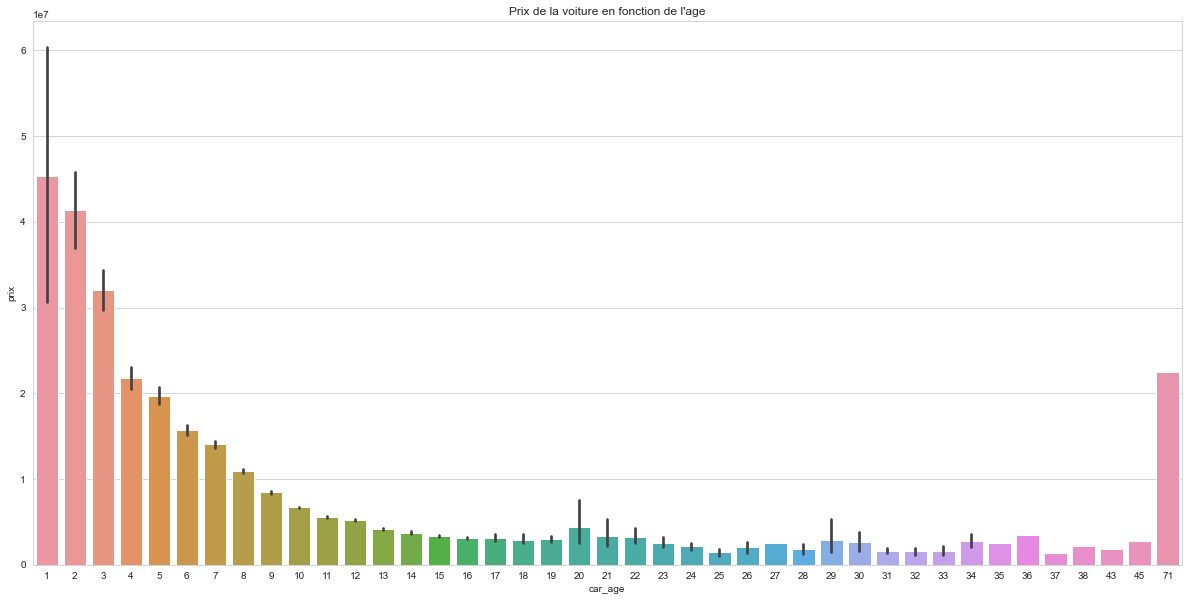

In [307]:
plt.figure(figsize=[70,10])
plt.subplot(1,3,1)
sns.barplot(dataframe['car_age'],dataframe['prix'])
plt.title("Prix de la voiture en fonction de l'age")
plt.show()

<AxesSubplot:xlabel='carburant', ylabel='car_age'>

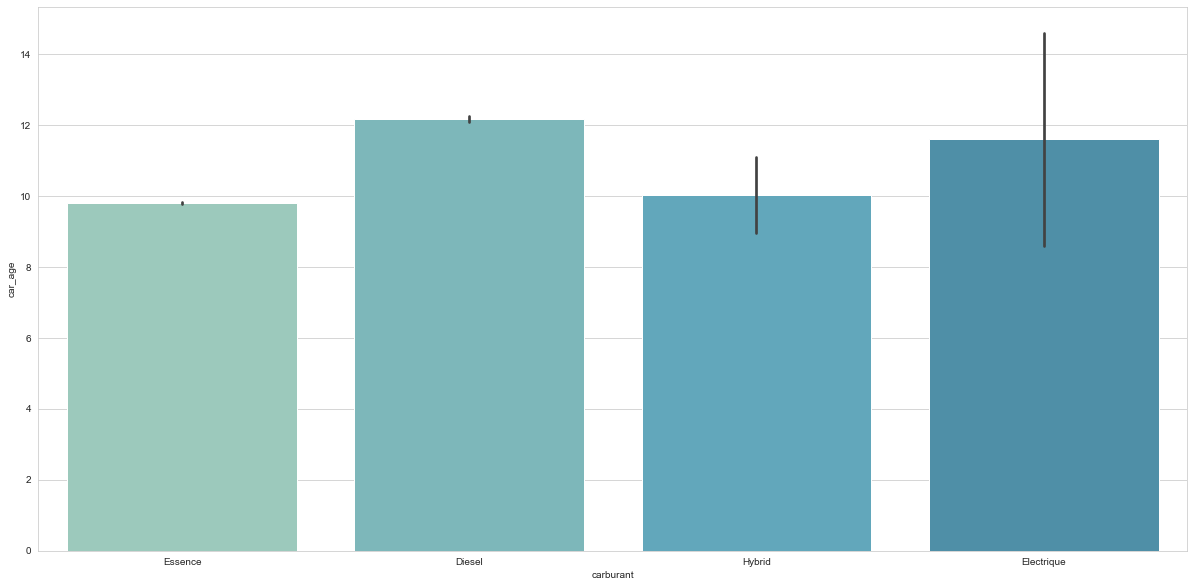

In [308]:
plt.figure(figsize=[70,10])
plt.subplot(1,3,2)
sns.barplot(dataframe['carburant'],dataframe['car_age'])

<AxesSubplot:xlabel='transmission', ylabel='kilometrage'>

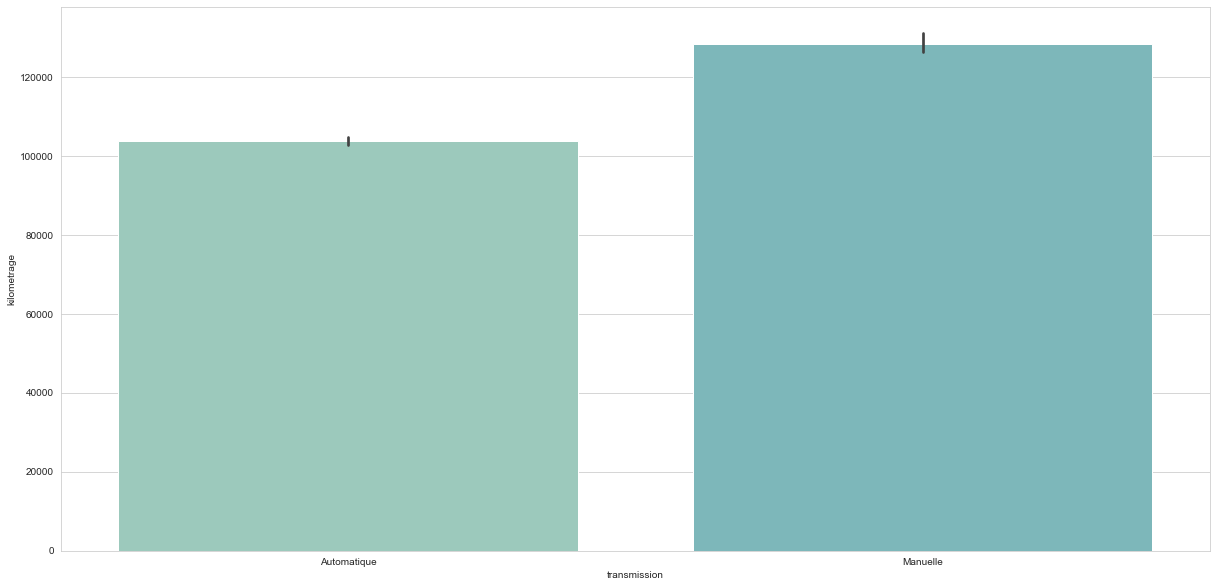

In [309]:
plt.figure(figsize=[70,10])
plt.subplot(1,3,2)
sns.barplot(dataframe['transmission'],dataframe['kilometrage'])


Text(0.5, 1.0, 'Distribution of Selling Price')

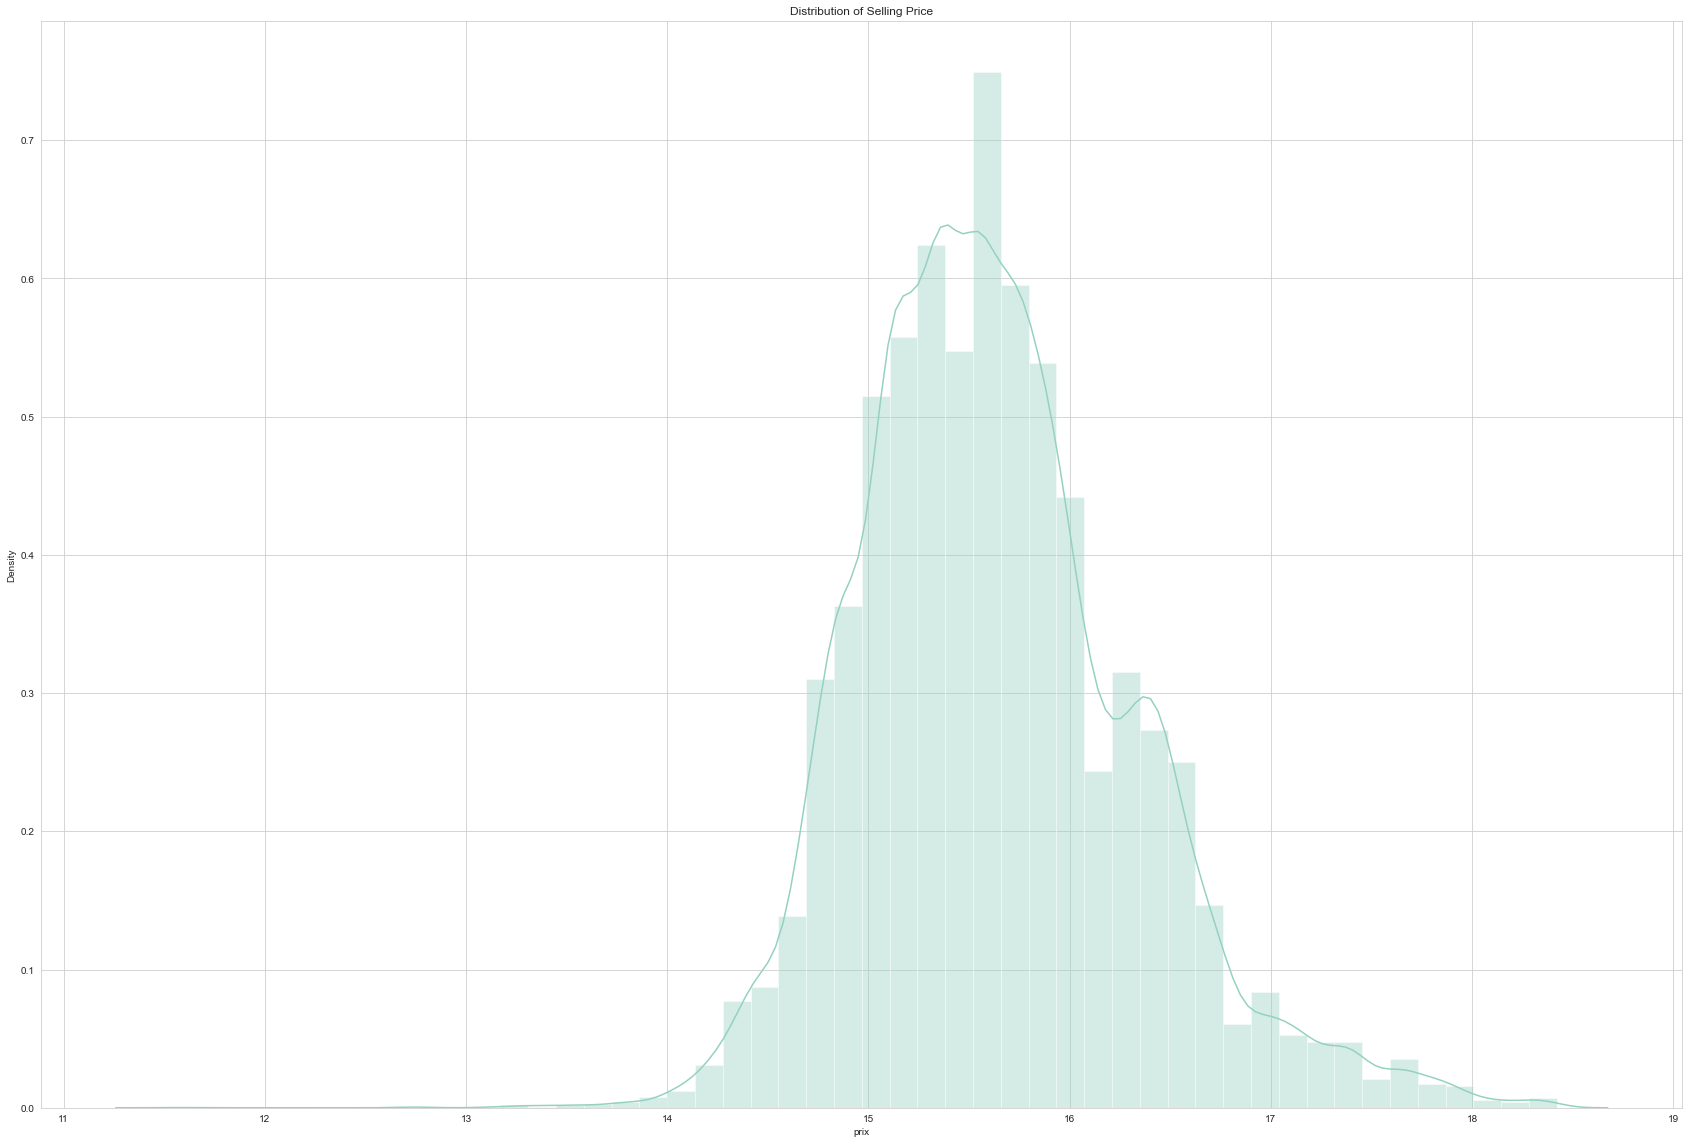

In [310]:
plt.figure(figsize=[100,20])

plt.subplot(1,3,2 )
sns.distplot(np.log(dataframe['prix']))
plt.title('Distribution of Selling Price')


Text(0.5, 1.0, 'Distribution of KMS Drived')

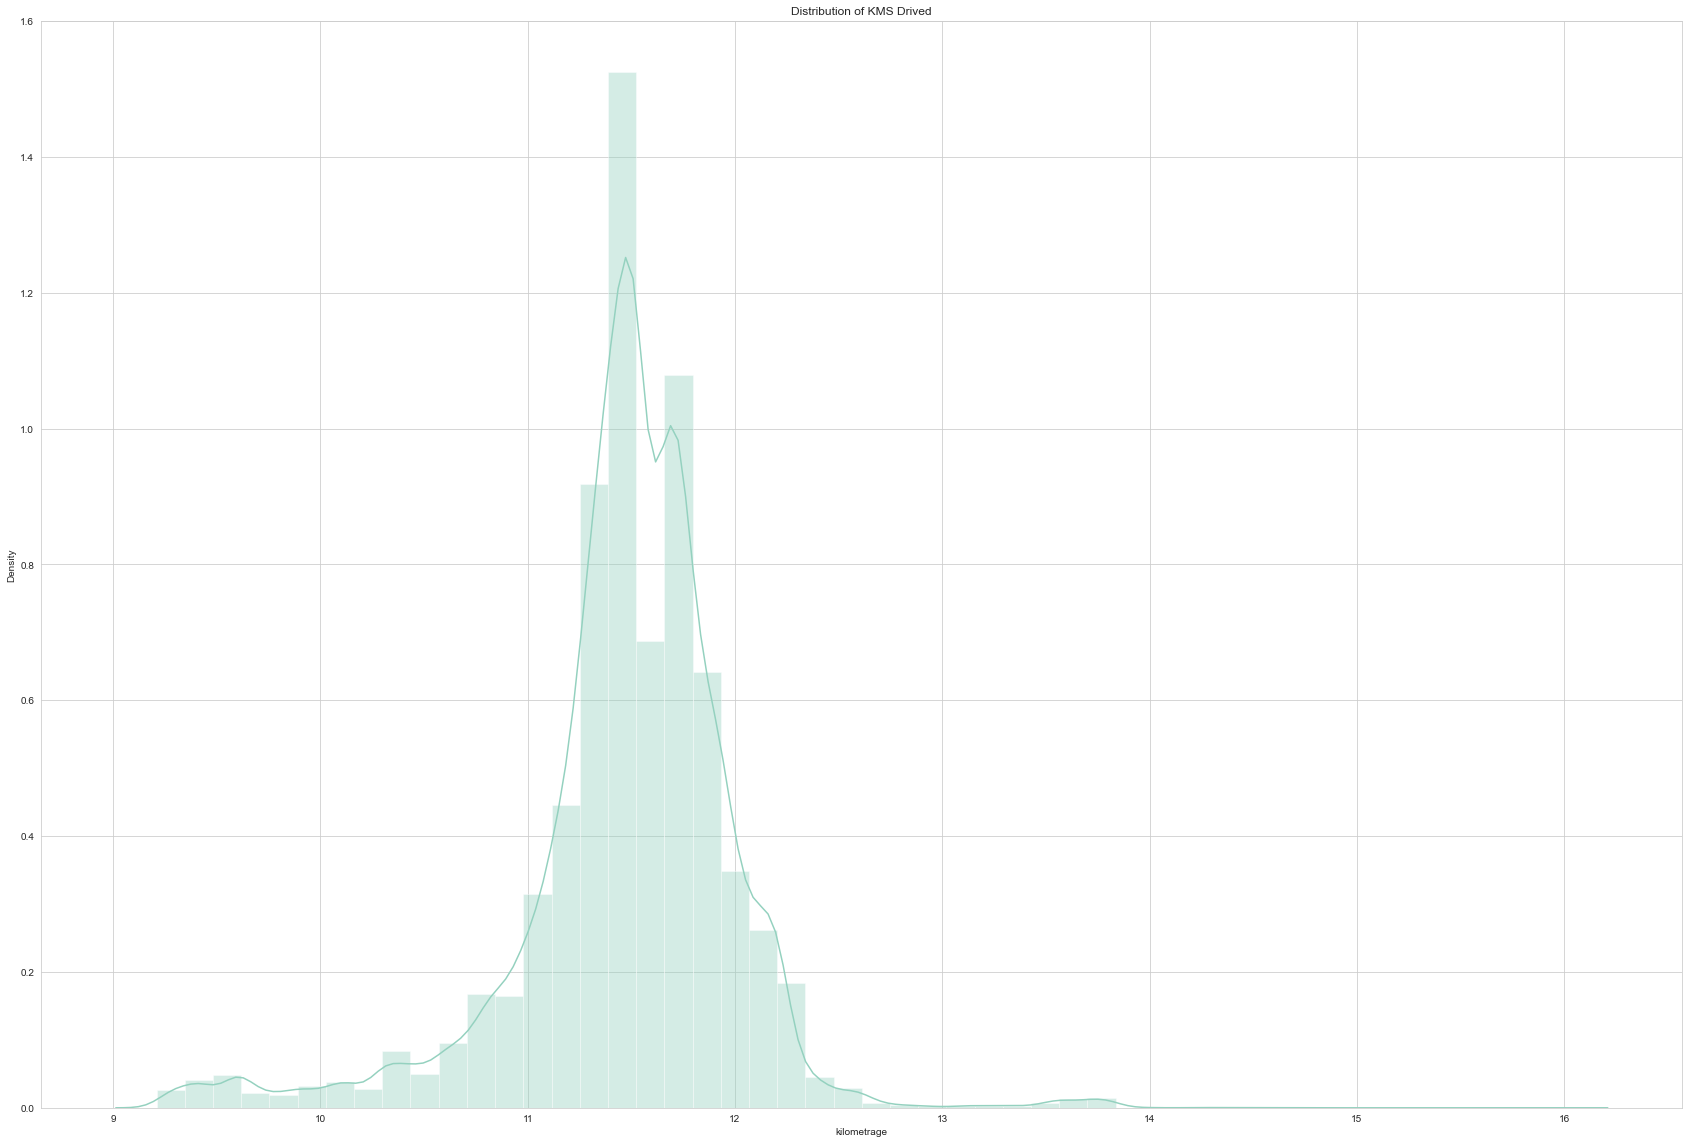

In [281]:
plt.figure(figsize=[100,20])
plt.subplot(1,3,2)
# dataframe['kilometrage'].plot.density(color='green')
sns.distplot(np.log(dataframe['kilometrage']))
plt.title('Distribution of KMS Drived')

**Dealing With Categorical Variables**

In [311]:
# Here's our categorical column
print(dataframe['carburant'].unique())
print(dataframe['transmission'].unique())
print(dataframe['marque'].unique())

['Essence' 'Diesel' 'Hybrid' 'Electrique']
['Automatique' 'Manuelle']
['Mitsubishi' 'BMW' 'Ford' 'Fiat' 'Hyundai' 'Toyota' 'Mercedes-Benz'
 'Chevrolet' 'Nissan' 'Hummer' 'Kia' 'Tata' 'Seat' 'Peugeot' 'Jeep'
 'Renault' 'Dodge' 'Citroen' 'Mazda' 'Honda' 'Land Rover' 'Audi'
 'Cadillac' 'Volkswagen' 'Maserati' 'Suzuki' 'Dacia' 'Opel' 'GMC'
 'Chrysler' 'Iveco' 'Alfa Romeo' 'Jaguar' 'SAIC' 'Infiniti' 'Skoda'
 'Rover' 'GAC' 'Lincoln' 'Mini' 'Porsche' 'Acura' 'Buick' 'SsangYong'
 'Subaru' 'Lexus' 'Chery' 'Great Wall' 'Lancia' 'Smart' 'Saturn' 'Volvo'
 'Foton' 'Isuzu' 'Pontiac' 'Lifan' 'Bentley' 'Dongfeng' 'DS' 'Haval'
 'MINI' 'Daewoo' 'Lamborghini' 'Daihatsu' 'SEAT' 'Bmw']
